# Cats and Dogs Dataset

In [1]:
Kaggle_cats_dogs = r"C:\Data\Kaggle\kagglecatsanddogs_3367a\PetImages"

In [31]:
import os
import glob
import shutil
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# PyTorch imports
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# sklearn imports for classification, clustering, and metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    silhouette_score,
)
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import umap
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.manifold import TSNE


In [3]:
# CUDA !!

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# I have cuda so alot of features and labels will be moved to GPU for acceleration

Using device: cuda


# Functions

In [35]:
def GMM(data, n_clusters = 3):
    
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm_labels = gmm.fit_predict(data)
    
    return gmm_labels

def GMM_means(data, n_clusters = 3):
    
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm_labels = gmm.fit_predict(data)
    
    return gmm.means_

def sil_score(data, cluster_labels, cluster_type):
    
    score = silhouette_score(data, cluster_labels, metric='euclidean')
    
    print(f"Silhouette Score for {cluster_type} : {score:.3f}")
def purity_score(y_true, y_pred):
    # Create confusion matrix
    contingency_matrix = confusion_matrix(y_true, y_pred)
    # Calculate purity
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

In [5]:
def evaluate(feature_extractor, fc_layer, dataloader):
    feature_extractor.eval()  # Set feature extractor to evaluation mode
    fc_layer.eval()           # Set fully connected layer to evaluation mode
    correct_predictions = 0

    with torch.no_grad():  # No gradient calculations needed
        for images, labels in dataloader:
            # Move images and labels to the device
            images, labels = images.to(device), labels.to(device)

            # Extract features using the feature extractor
            features = feature_extractor(images)
            features = features.flatten(start_dim=1)  # Flatten the features

            # Forward pass through the FC layer
            outputs = fc_layer(features)
            _, preds = torch.max(outputs, 1)  # Get predicted class
            correct_predictions += torch.sum(preds == labels)  # Compare with true labels

    # Calculate accuracy
    accuracy = correct_predictions.double() / len(dataloader.dataset)
    print(f'SVM Test Accuracy on trained Features: {accuracy:.4f}')
    return accuracy.item()

def train_and_evaluate_svm(features, labels, test_size=0.2, kernel='linear', C=1.0, random_state=42):

    # Convert labels to numeric indices
    label_to_index = {label: idx for idx, label in enumerate(set(labels))}
    numeric_labels = [label_to_index[label] for label in labels]

    # Split features and labels into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, numeric_labels, 
                                                        test_size=test_size, 
                                                        random_state=random_state)

    # Train an SVM classifier
    svm = SVC(kernel=kernel, C=C, random_state=random_state)
    svm.fit(X_train, y_train)

    # Predict on the test set
    y_pred = svm.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"SVM Accuracy on extracted features: {accuracy:.4f}")
    
    return accuracy

In [29]:
def plot_clusters(data, labels, title, feature_labels):
    
    plt.figure(figsize=(10, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, s=10)
    plt.xlabel(f'{feature_labels} 1')
    plt.ylabel(f'{feature_labels} 2')
    plt.title(title)
    plt.grid(True)
    plt.show()

In [6]:
# This can be used when evaluating the accuracy of the DNN's

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation for ImageNet
])

# Load the full dataset
full_dataset = datasets.ImageFolder(root=Kaggle_cats_dogs, transform=transform)

# Split dataset into 80% train and 20% test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Resnet 18 Feature Extraction

In [7]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalisation for ImageNet
])

# Load the dataset
dataset = datasets.ImageFolder(root=Kaggle_cats_dogs, transform=transform)

# Get folder names as labels
folder_labels = list(dataset.class_to_idx.keys())
print("Folder labels:", folder_labels)

# Create DataLoader
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Load ResNet-18 pre-trained on ImageNet
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet18 = resnet18.to(device)  # Move model to GPU
resnet18.eval()  # Set to evaluation mode

# Remove the fully connected layer to use ResNet as a feature extractor
res_feature_extractor = torch.nn.Sequential(*list(resnet18.children())[:-1])
res_feature_extractor = res_feature_extractor.to(device)  # Move feature extractor to GPU

# Extract features and assign folder labels
res_features = []
res_labels = []

with torch.no_grad():  # No gradients needed for feature extraction
    for inputs, targets in data_loader:
        # Move inputs and targets to GPU
        inputs = inputs.to(device)
        
        # Extract features
        features = res_feature_extractor(inputs)
        features = features.flatten(start_dim=1)
        res_features.append(features)

        # Use folder labels instead of numeric labels
        folder_names = [folder_labels[target] for target in targets]
        res_labels.extend(targets.cpu().tolist())

# Combine features into a single tensor
res_features = torch.cat(res_features, dim=0)

# Moving features to CPU if needed for further processing
res_features = res_features.cpu()

# Print results
print("Feature tensor shape:", res_features.shape)
print("First 10 folder labels:", res_labels[:10])

Folder labels: ['Cat', 'Dog']


C:\Users\Mohammed Ameen Dasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Feature tensor shape: torch.Size([24959, 512])
First 10 folder labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Check clusters using Resnet 18 Features

In [38]:
# Apply UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_features = umap_reducer.fit_transform(res_features)

# Visualise UMAP
plt.figure(figsize=(10, 6))
plt.scatter(umap_features[:, 0], umap_features[:, 1], c=res_labels, s=5)
plt.title("UMAP Visualisation")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.show()

silhouette_avg = silhouette_score(umap_features, GMM(umap_features, 2))
print(f"Silhouette Score TSNE + UMAP: {silhouette_avg:.2f}")
purity = purity_score(np.array(res_labels), np.array(GMM(umap_features, 2)))
print(f"Purity: {purity:.3f}")

C:\Users\Mohammed Ameen Dasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Mohammed Ameen Dasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Silhouette Score TSNE + UMAP: 0.73
Purity: 0.986


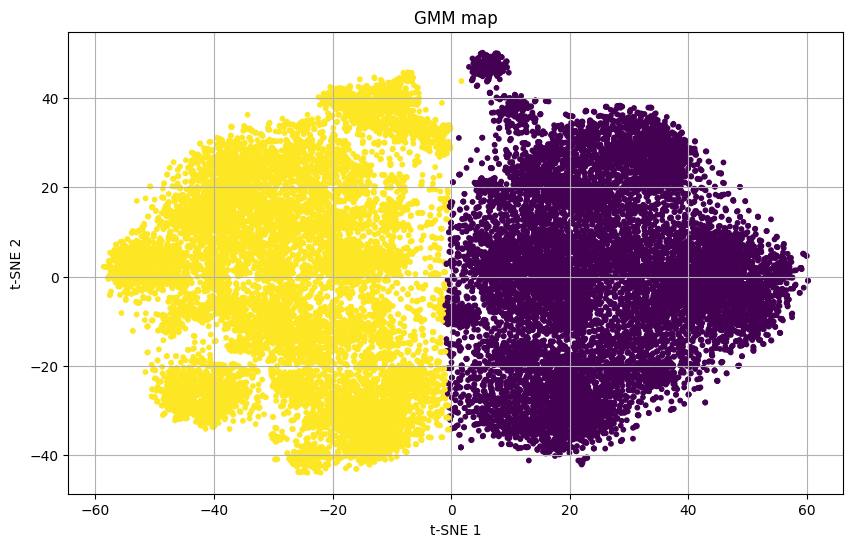

In [32]:
TSNE = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
TSNE_embe = TSNE.fit_transform(res_features)

plot_clusters(TSNE_embe, GMM(TSNE_embe,2), 'GMM map', 't-SNE')

## Training Resnet 18 

In [9]:
import torch

# Save to a file
torch.save((res_features, res_labels), "Kaggle_f_l.pth")
print("Features and labels saved successfully!")

Features and labels saved successfully!


In [10]:
# Load precomputed features and labels
features, labels = torch.load("Kaggle_f_l.pth", weights_only=True)

training_features_res = torch.tensor(features)
training_labels_res = torch.tensor(labels)
# Create a DataLoader for training
dataset = TensorDataset(training_features_res, training_labels_res)
data_loader_resnet = DataLoader(dataset, batch_size=32, shuffle=True)



# Define the fully connected layer
num_classes = 2
input_dim = training_features_res.shape[1]  # Dimension of the extracted features
fc_layer = nn.Linear(input_dim, num_classes)

# Define optimiser and loss function
optimiser = optim.Adam(fc_layer.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 10
fc_layer.train()  # Set to training mode

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0  # initialise correct predictions counter for each epoch

    for inputs, targets in data_loader_resnet:
        # Forward pass
        outputs = fc_layer(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimisation
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        running_loss += loss.item()

        # Calculate predictions and accuracy
        _, preds = torch.max(outputs, 1)  # Get the predicted class indices
        correct_predictions += torch.sum(preds == targets).item()

    # Calculate epoch loss and accuracy
    epoch_loss = running_loss / len(data_loader_resnet)
    epoch_acc = correct_predictions / len(dataset) 

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


# Save the trained layer
torch.save(fc_layer.state_dict(), "trained_fc_layer.pth")
print("Trained fully connected layer saved.")

C:\Users\Mohammed Ameen Dasu\AppData\Local\Temp\ipykernel_41912\978741070.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  training_features_res = torch.tensor(features)


Epoch [1/10], Loss: 0.0623, Accuracy: 0.9790
Epoch [2/10], Loss: 0.0360, Accuracy: 0.9872
Epoch [3/10], Loss: 0.0339, Accuracy: 0.9876
Epoch [4/10], Loss: 0.0309, Accuracy: 0.9895
Epoch [5/10], Loss: 0.0310, Accuracy: 0.9890
Epoch [6/10], Loss: 0.0297, Accuracy: 0.9897
Epoch [7/10], Loss: 0.0285, Accuracy: 0.9903
Epoch [8/10], Loss: 0.0286, Accuracy: 0.9902
Epoch [9/10], Loss: 0.0282, Accuracy: 0.9898
Epoch [10/10], Loss: 0.0283, Accuracy: 0.9897
Trained fully connected layer saved.


In [11]:
# Refined Features here

fc_layer.eval()  # Set to evaluation mode
with torch.no_grad():
    refined_features = fc_layer(training_features_res).numpy()

print(refined_features.shape)

(24959, 2)


## Evaluations of Resnet 18

### Before Training

In [12]:
test_accuracy = train_and_evaluate_svm(res_features, res_labels)

SVM Accuracy on extracted features: 0.9816


### After Training

In [13]:
# Evaluate the model on the test set
fc_layer = fc_layer.to(device)  # Ensure the FC layer is on the same device
test_accuracy = evaluate(res_feature_extractor, fc_layer, test_loader)

SVM Test Accuracy on trained Features: 0.9918


# VGG 16 Feature Extraction

In [14]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for VGG16
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalisation for ImageNet
])

# Load the dataset
dataset = datasets.ImageFolder(root=Kaggle_cats_dogs, transform=transform)

# Use `dict_values` directly
breed_values = list(dataset.class_to_idx.keys())  # Get your custom labels
print("Custom labels from dict_values:", breed_values)

# Create DataLoader
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# Load VGG16 pre-trained on ImageNet
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
vgg16 = vgg16.to(device)  # Move model to GPU
vgg16.eval()  # Set to evaluation mode

# Remove the fully connected layers to use VGG16 as a feature extractor
vgg_feature_extractor = torch.nn.Sequential(*list(vgg16.features.children()))
vgg_feature_extractor = vgg_feature_extractor.to(device)  # Move feature extractor to GPU

# Extract features and assign labels
vgg_features = []
vgg_labels = []

with torch.no_grad():  # No gradients needed for feature extraction
    for inputs, targets in data_loader:
        # Move inputs to GPU
        inputs = inputs.to(device)

        # Extract features
        features = vgg_feature_extractor(inputs)
        features = features.flatten(start_dim=1)  # Flatten the spatial dimensions
        vgg_features.append(features)

        # Directly use dict_values to assign labels
        vgg_labels.extend(targets.numpy().tolist())  # Use numeric indices directly

# Combine features into a single tensor
vgg_features = torch.cat(vgg_features, dim=0)

# Move features to CPU if needed for further processing
vgg_features = vgg_features.cpu()

# Print results
print("Feature tensor shape:", vgg_features.shape)
print("First 10 custom labels:", vgg_labels[:10])

Custom labels from dict_values: ['Cat', 'Dog']


C:\Users\Mohammed Ameen Dasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Feature tensor shape: torch.Size([24959, 25088])
First 10 custom labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Checking Clusters 

In [37]:
# Training with VGG inital
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_features = umap_reducer.fit_transform(vgg_features)


# Visualise UMAP
plt.figure(figsize=(10, 6))
plt.scatter(umap_features[:, 0], umap_features[:, 1], c=labels, cmap='Spectral', s=5)
plt.title("UMAP Visualisation")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.show()

silhouette_avg = silhouette_score(umap_features, GMM(umap_features, 2))
print(f"Silhouette Score TSNE + UMAP: {silhouette_avg:.2f}")
purity = purity_score(np.array(vgg_labels), np.array(GMM(umap_features, 2)))
print(f"Purity: {purity:.3f}")

C:\Users\Mohammed Ameen Dasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Mohammed Ameen Dasu\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Silhouette Score TSNE + UMAP: 0.59
Purity: 0.973


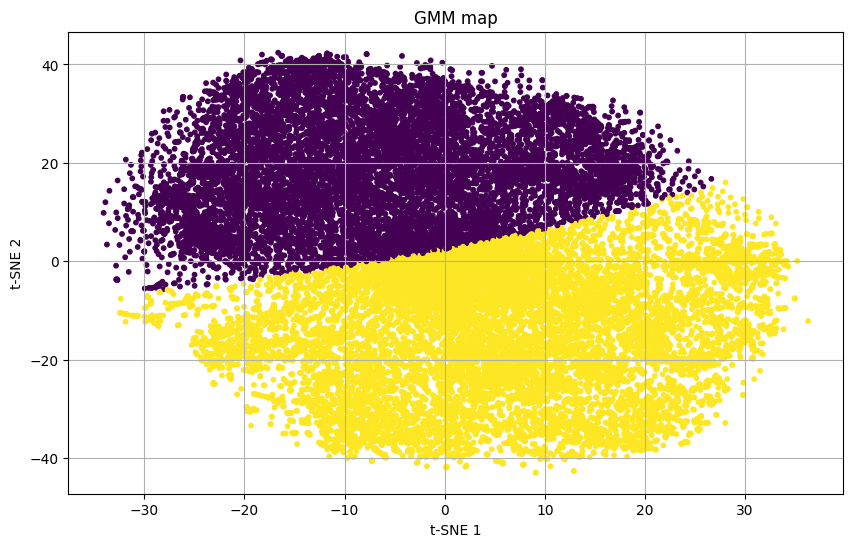

In [34]:
from sklearn.manifold import TSNE

TSNE = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
TSNE_embe = TSNE.fit_transform(vgg_features)

plot_clusters(TSNE_embe, GMM(TSNE_embe,2), 'GMM map', 't-SNE')

## Training VGG - 16

In [16]:
# Save the Features and Labels above

# Save extracted features and labels
torch.save((vgg_features, vgg_labels), "vgg_f_l.pth")
print("Features and labels saved.")


Features and labels saved.


In [17]:
# Load precomputed features and labels
features, labels = torch.load("vgg_f_l.pth", weights_only = True)

features = torch.tensor(features)
labels = torch.tensor(labels)

# Create a DataLoader for training
dataset = TensorDataset(features, labels)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the fully connected layer
num_classes = 2
input_dim = features.shape[1]  # Dimension of the extracted features
vgg_layer = nn.Linear(input_dim, num_classes)
vgg_layer = vgg_layer.to(device)  # Move model to GPU

# Define optimiser and loss function
optimiser = optim.Adam(vgg_layer.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
num_epochs = 10
vgg_layer.train()  # Set to training mode

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0  # initialise correct predictions counter for each epoch

    for inputs, targets in data_loader:
        # Move inputs and targets to GPU
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = vgg_layer(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimisation
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        running_loss += loss.item()

        # Calculate predictions and accuracy
        _, preds = torch.max(outputs, 1)  # Get the predicted class indices
        correct_predictions += torch.sum(preds == targets).item()

    # Calculate epoch loss and accuracy
    epoch_loss = running_loss / len(data_loader)
    epoch_acc = correct_predictions / len(dataset)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

C:\Users\Mohammed Ameen Dasu\AppData\Local\Temp\ipykernel_41912\657560674.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features)


Epoch [1/10], Loss: 0.1845, Accuracy: 0.9766
Epoch [2/10], Loss: 0.0698, Accuracy: 0.9929
Epoch [3/10], Loss: 0.0428, Accuracy: 0.9953
Epoch [4/10], Loss: 0.0365, Accuracy: 0.9960
Epoch [5/10], Loss: 0.0310, Accuracy: 0.9967
Epoch [6/10], Loss: 0.0144, Accuracy: 0.9980
Epoch [7/10], Loss: 0.0351, Accuracy: 0.9970
Epoch [8/10], Loss: 0.0314, Accuracy: 0.9973
Epoch [9/10], Loss: 0.0223, Accuracy: 0.9981
Epoch [10/10], Loss: 0.0198, Accuracy: 0.9983


In [18]:
# Move the trained FC layer to the GPU
vgg_layer = vgg_layer.to(device)
vgg_layer.eval()  
# Set the layer to evaluation mode

# Move features to the GPU
features = features.to(device)

# Extract refined features
with torch.no_grad():  # No gradients needed for inference
    vgg_tuned = vgg_layer(features).cpu().numpy()  # Move results to CPU for further processing

# Print the shape of the refined features
print("Refined features shape:", vgg_tuned.shape)

Refined features shape: (24959, 2)


## Evaluations of VGG - 16 

### Before Training

In [19]:
test_accuracy = train_and_evaluate_svm(vgg_features, vgg_labels)

SVM Accuracy on extracted features: 0.9862


### After Training

In [20]:
vgg_layer = vgg_layer.to(device)  # Ensure the FC layer is on the same device
test_accuracy = evaluate(vgg_feature_extractor, vgg_layer, test_loader)

SVM Test Accuracy on trained Features: 0.9980


# Confusion Matrix's

In [21]:
def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

## Resnet 18 - Classification

### Before Training

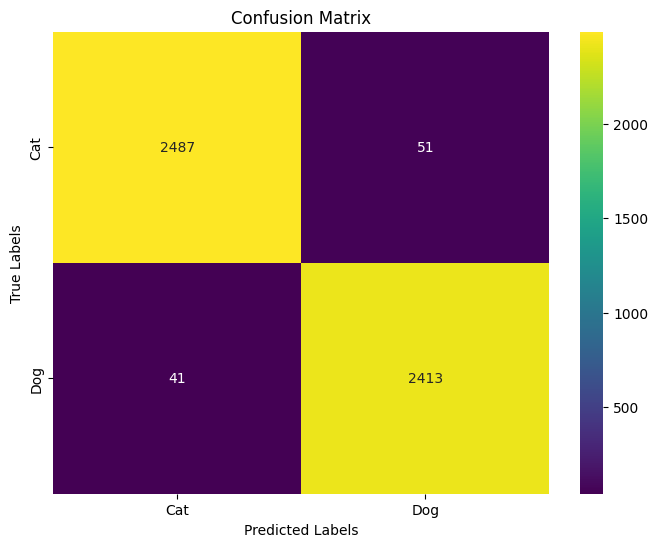


Classification Report:
               precision    recall  f1-score   support

         Cat       0.98      0.98      0.98      2538
         Dog       0.98      0.98      0.98      2454

    accuracy                           0.98      4992
   macro avg       0.98      0.98      0.98      4992
weighted avg       0.98      0.98      0.98      4992



In [22]:
# Convert features and labels to NumPy arrays
res_features_np = res_features.numpy()
res_labels_np = np.array(res_labels)

# Train-Test split
from sklearn.model_selection import train_test_split
cat_dog_features_train, cat_dog_features_test, cat_dog_labels_train, cat_dog_labels_test = train_test_split(res_features_np, res_labels_np, test_size=0.2, random_state=42)

# Train an SVM
svm = SVC(kernel='linear', random_state=42)
svm.fit(cat_dog_features_train, cat_dog_labels_train)

# Make predictions
cat_dog_predictions  = svm.predict(cat_dog_features_test)

# Class names
class_names = ['Cat', 'Dog']
plot_confusion_matrix(cat_dog_labels_test,cat_dog_predictions, class_names)

# Print classification report
print("\nClassification Report:\n", classification_report(cat_dog_labels_test, cat_dog_predictions, target_names=class_names))

### After Training

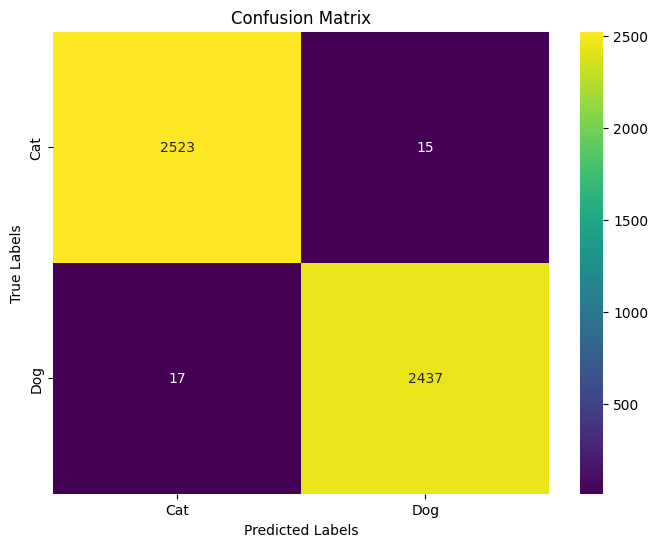


Classification Report:
               precision    recall  f1-score   support

         Cat       0.99      0.99      0.99      2538
         Dog       0.99      0.99      0.99      2454

    accuracy                           0.99      4992
   macro avg       0.99      0.99      0.99      4992
weighted avg       0.99      0.99      0.99      4992



In [23]:
# Convert features and labels to NumPy arrays
refined_features_np = refined_features
res_labels_np = np.array(res_labels)

# Train-Test split
from sklearn.model_selection import train_test_split
cat_dog_features_train, cat_dog_features_test, cat_dog_labels_train, cat_dog_labels_test = train_test_split(refined_features_np, res_labels_np, test_size=0.2, random_state=42)

# Train an SVM
svm = SVC(kernel='linear', random_state=42)
svm.fit(cat_dog_features_train, cat_dog_labels_train)

# Make predictions
cat_dog_predictions  = svm.predict(cat_dog_features_test)

# Compute confusion matrix
cm = confusion_matrix(cat_dog_labels_test, cat_dog_predictions )


# Class names
class_names = ['Cat', 'Dog']
plot_confusion_matrix(cat_dog_labels_test,cat_dog_predictions, class_names)

# Print classification report
print("\nClassification Report:\n", classification_report(cat_dog_labels_test, cat_dog_predictions, target_names=class_names))

## VGG - 16 - Classification

### Before Training

[[2511   27]
 [  42 2412]]


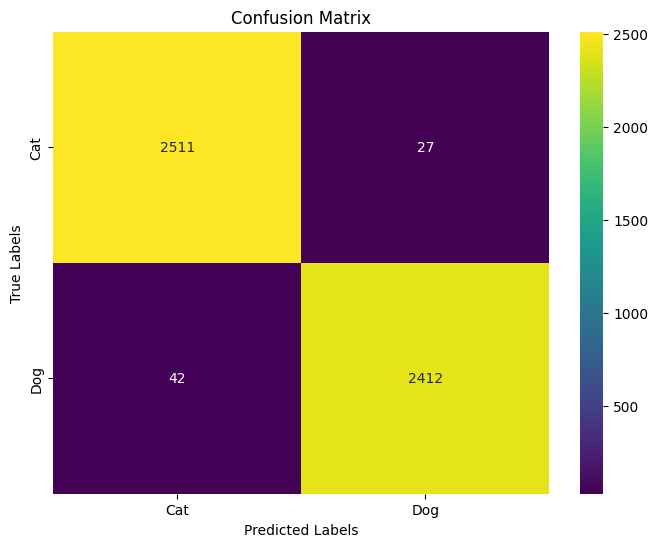


Classification Report:
               precision    recall  f1-score   support

         Cat       0.98      0.99      0.99      2538
         Dog       0.99      0.98      0.99      2454

    accuracy                           0.99      4992
   macro avg       0.99      0.99      0.99      4992
weighted avg       0.99      0.99      0.99      4992



In [24]:
# Convert features and labels to NumPy arrays
vgg_features_np = vgg_features.numpy()
vgg_labels_np = np.array(vgg_labels)

# Train-Test split
from sklearn.model_selection import train_test_split
cat_dog_features_train, cat_dog_features_test, cat_dog_labels_train, cat_dog_labels_test = train_test_split(vgg_features_np, vgg_labels_np, test_size=0.2, random_state=42)

# Train an SVM
svm = SVC(kernel='linear', random_state=42)
svm.fit(cat_dog_features_train, cat_dog_labels_train)

# Make predictions
cat_dog_predictions  = svm.predict(cat_dog_features_test)

# Compute confusion matrix
cm = confusion_matrix(cat_dog_labels_test, cat_dog_predictions)

print(cm)
# Class names
class_names = ['Cat', 'Dog']
plot_confusion_matrix(cat_dog_labels_test,cat_dog_predictions, class_names)

# Print classification report
print("\nClassification Report:\n", classification_report(cat_dog_labels_test, cat_dog_predictions, target_names=class_names))

### After Training

[[2535    3]
 [   1 2453]]


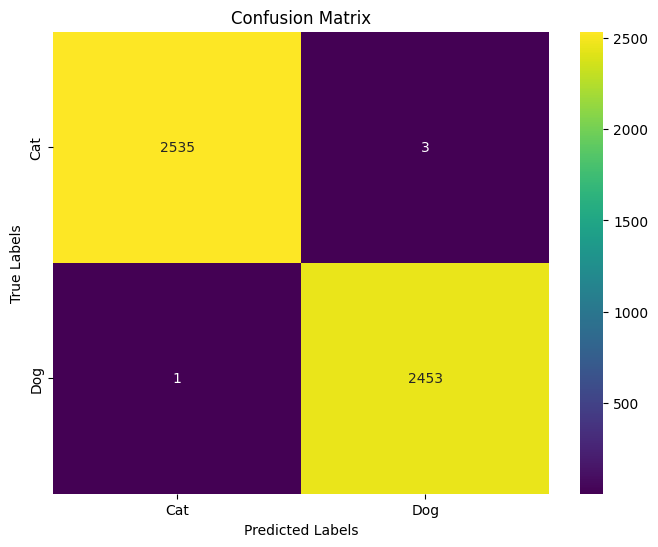


Classification Report:
               precision    recall  f1-score   support

         Cat       1.00      1.00      1.00      2538
         Dog       1.00      1.00      1.00      2454

    accuracy                           1.00      4992
   macro avg       1.00      1.00      1.00      4992
weighted avg       1.00      1.00      1.00      4992



In [25]:
# Convert features and labels to NumPy arrays
vgg_features_np = vgg_tuned
vgg_labels_np = np.array(vgg_labels)

# Train-Test split
from sklearn.model_selection import train_test_split
cat_dog_features_train, cat_dog_features_test, cat_dog_labels_train, cat_dog_labels_test = train_test_split(vgg_features_np, vgg_labels_np, test_size=0.2, random_state=42)

# Train an SVM
svm = SVC(kernel='linear', random_state=42)
svm.fit(cat_dog_features_train, cat_dog_labels_train)

# Make predictions
cat_dog_predictions  = svm.predict(cat_dog_features_test)

# Compute confusion matrix
cm = confusion_matrix(cat_dog_labels_test, cat_dog_predictions)

print(cm)
# Class names
class_names = ['Cat', 'Dog']
plot_confusion_matrix(cat_dog_labels_test,cat_dog_predictions, class_names)

# Print classification report
print("\nClassification Report:\n", classification_report(cat_dog_labels_test, cat_dog_predictions, target_names=class_names))

# Fin